<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task10_(Lite)_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.0rc1 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 191 kB 13.0 MB/s 
     |████████████████████████████████| 454.4 MB 9.2 kB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 462 kB 48.2 MB/s 
     |████████████████████████████████| 4.0 MB 41.2 MB/s 
     |████████████████████████████████| 92.7 MB 38 kB/s 
     |████████████████████████████████| 3.0 MB 36.0 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 367 kB 52.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.0rc1 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
import time, random
from google.colab import files
from google.colab import drive
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Activation, Lambda, LeakyReLU #Базовые слои
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, multivariate_normal # модуль с нормальными непрерывными случайными величинами
from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Mounted at /content/drive


#CVAE

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test

x_train = x_train.astype('float32')/255 # представляем в виде значений от 0 до 1
x_test = x_test.astype('float32')/255
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)

y_train_cat = to_categorical(y_train, 10).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test, 10).astype(np.float32)# переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

print(x_train.shape)
print(x_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)
print(num_classes)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)
10


In [ ]:
batch_size = 125 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.2 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(600, activation='relu')(x) # полносвязный слой на 200 нейронов
    #x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(300, activation='relu')(x) # полносвязный слой на 200 нейронов
    #x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(150, activation='relu')(x) # полносвязный слой на 200 нейронов
    #x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(150)(x) # полносвязный слой на 200 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = Dense(300)(x) # полносвязный слой на 200 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = Dense(600)(x) # полносвязный слой на 200 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием
generator = models["decoder"]

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
def plotImages(xTrain, pred, shape=(28, 28)): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(25, 5)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 28*28      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 28*28     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        #clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plotImages(imgs, decoded, shape=(28,28))
    
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

Train on 60000 samples, validate on 10000 samples
Epoch 1/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.1456

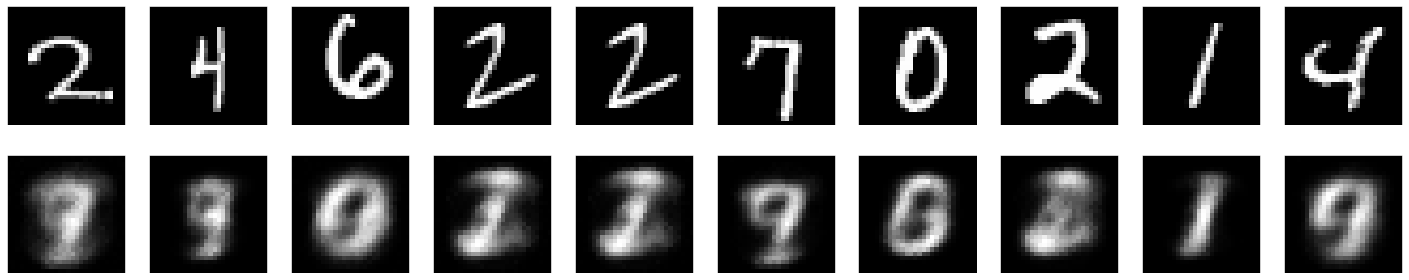

60000/60000 [==============================] - 36s 599us/sample - loss: 0.1455 - val_loss: 0.1145
Epoch 2/101
60000/60000 [==============================] - 34s 568us/sample - loss: 0.1031 - val_loss: 0.0944
Epoch 3/101
60000/60000 [==============================] - 34s 568us/sample - loss: 0.0903 - val_loss: 0.0861
Epoch 4/101
60000/60000 [==============================] - 34s 570us/sample - loss: 0.0846 - val_loss: 0.0819
Epoch 5/101
60000/60000 [==============================] - 35s 579us/sample - loss: 0.0811 - val_loss: 0.0791
Epoch 6/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0787

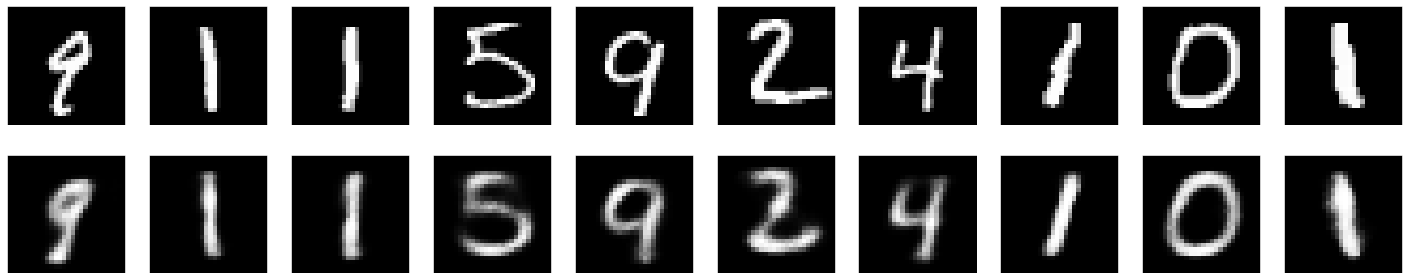

60000/60000 [==============================] - 36s 599us/sample - loss: 0.0787 - val_loss: 0.0769
Epoch 7/101
60000/60000 [==============================] - 34s 574us/sample - loss: 0.0770 - val_loss: 0.0755
Epoch 8/101
60000/60000 [==============================] - 34s 573us/sample - loss: 0.0756 - val_loss: 0.0743
Epoch 9/101
60000/60000 [==============================] - 35s 580us/sample - loss: 0.0746 - val_loss: 0.0735
Epoch 10/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0737 - val_loss: 0.0726
Epoch 11/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0729

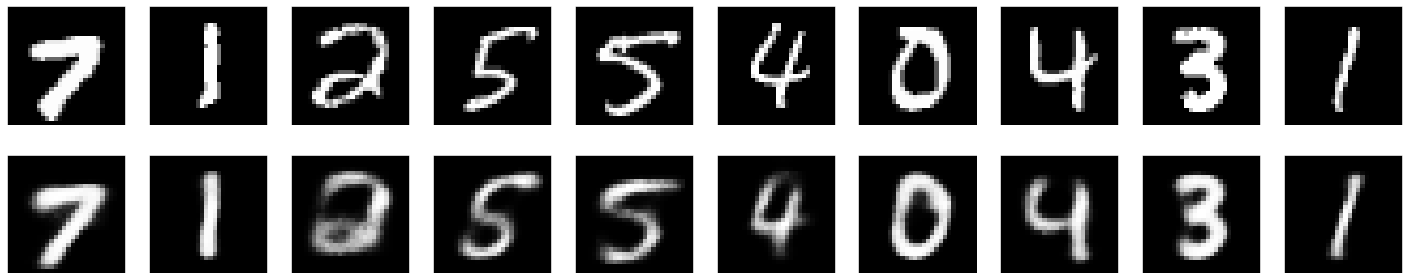

60000/60000 [==============================] - 35s 589us/sample - loss: 0.0729 - val_loss: 0.0720
Epoch 12/101
60000/60000 [==============================] - 34s 572us/sample - loss: 0.0722 - val_loss: 0.0714
Epoch 13/101
60000/60000 [==============================] - 34s 573us/sample - loss: 0.0717 - val_loss: 0.0709
Epoch 14/101
60000/60000 [==============================] - 34s 570us/sample - loss: 0.0711 - val_loss: 0.0702
Epoch 15/101
60000/60000 [==============================] - 34s 573us/sample - loss: 0.0706 - val_loss: 0.0699
Epoch 16/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0702

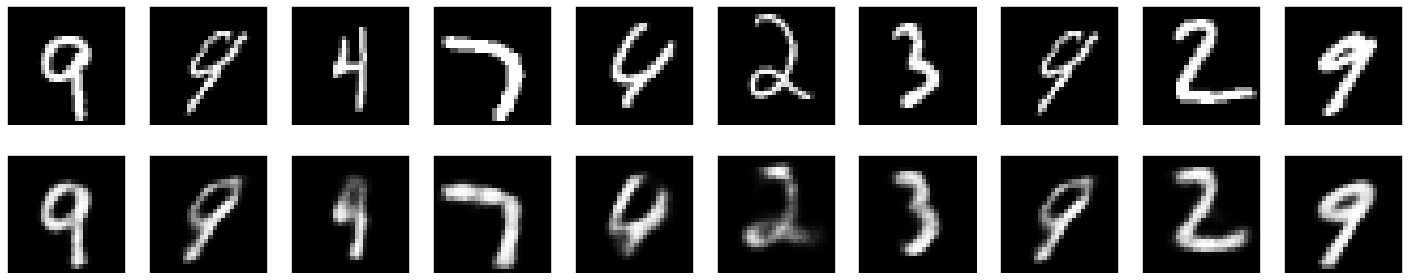

60000/60000 [==============================] - 36s 592us/sample - loss: 0.0702 - val_loss: 0.0694
Epoch 17/101
60000/60000 [==============================] - 34s 575us/sample - loss: 0.0697 - val_loss: 0.0691
Epoch 18/101
60000/60000 [==============================] - 35s 576us/sample - loss: 0.0693 - val_loss: 0.0687
Epoch 19/101
60000/60000 [==============================] - 35s 576us/sample - loss: 0.0690 - val_loss: 0.0684
Epoch 20/101
60000/60000 [==============================] - 34s 574us/sample - loss: 0.0686 - val_loss: 0.0680
Epoch 21/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0683

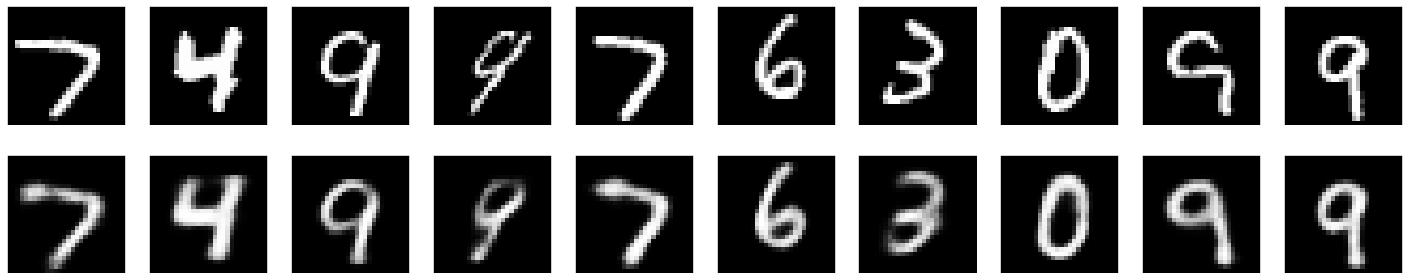

60000/60000 [==============================] - 35s 591us/sample - loss: 0.0683 - val_loss: 0.0677
Epoch 22/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0680 - val_loss: 0.0675
Epoch 23/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0678 - val_loss: 0.0672
Epoch 24/101
60000/60000 [==============================] - 35s 576us/sample - loss: 0.0675 - val_loss: 0.0671
Epoch 25/101
60000/60000 [==============================] - 35s 579us/sample - loss: 0.0673 - val_loss: 0.0669
Epoch 26/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0670

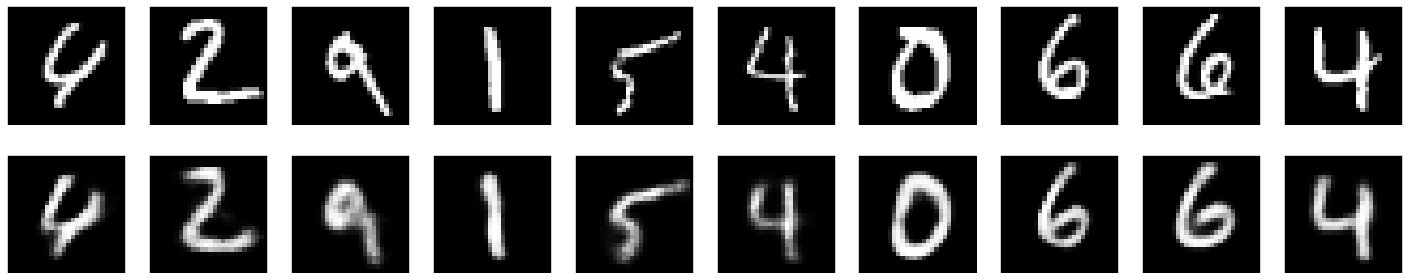

60000/60000 [==============================] - 36s 592us/sample - loss: 0.0670 - val_loss: 0.0666
Epoch 27/101
60000/60000 [==============================] - 35s 582us/sample - loss: 0.0668 - val_loss: 0.0664
Epoch 28/101
60000/60000 [==============================] - 35s 580us/sample - loss: 0.0666 - val_loss: 0.0662
Epoch 29/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0664 - val_loss: 0.0660
Epoch 30/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0662 - val_loss: 0.0659
Epoch 31/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0660

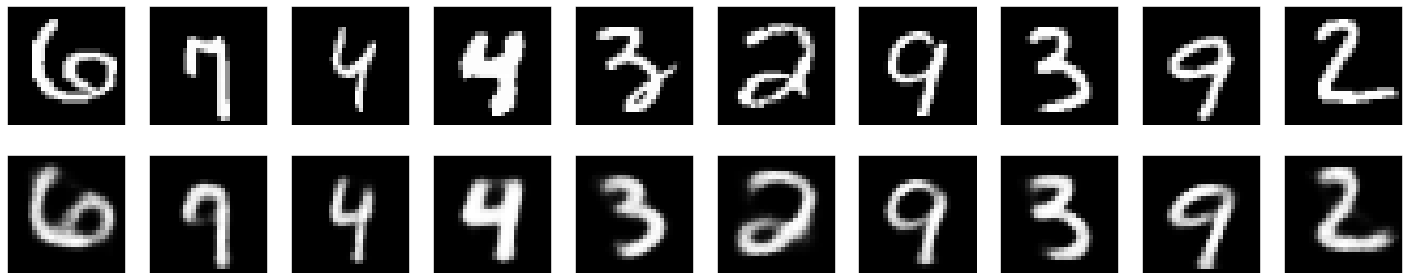

60000/60000 [==============================] - 36s 594us/sample - loss: 0.0661 - val_loss: 0.0658
Epoch 32/101
60000/60000 [==============================] - 35s 582us/sample - loss: 0.0659 - val_loss: 0.0656
Epoch 33/101
60000/60000 [==============================] - 35s 591us/sample - loss: 0.0657 - val_loss: 0.0655
Epoch 34/101
60000/60000 [==============================] - 35s 589us/sample - loss: 0.0656 - val_loss: 0.0653
Epoch 35/101
60000/60000 [==============================] - 35s 586us/sample - loss: 0.0655 - val_loss: 0.0653
Epoch 36/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0653

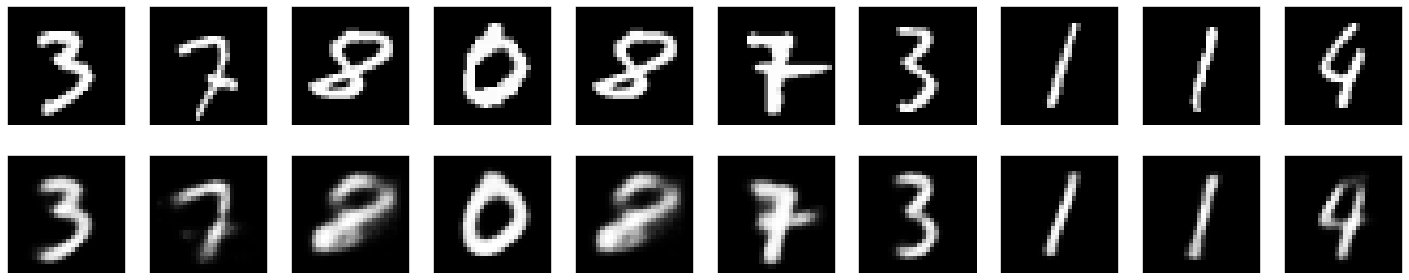

60000/60000 [==============================] - 36s 598us/sample - loss: 0.0653 - val_loss: 0.0651
Epoch 37/101
60000/60000 [==============================] - 35s 586us/sample - loss: 0.0652 - val_loss: 0.0650
Epoch 38/101
60000/60000 [==============================] - 35s 584us/sample - loss: 0.0650 - val_loss: 0.0648
Epoch 39/101
60000/60000 [==============================] - 35s 584us/sample - loss: 0.0649 - val_loss: 0.0648
Epoch 40/101
60000/60000 [==============================] - 35s 582us/sample - loss: 0.0648 - val_loss: 0.0646
Epoch 41/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0647

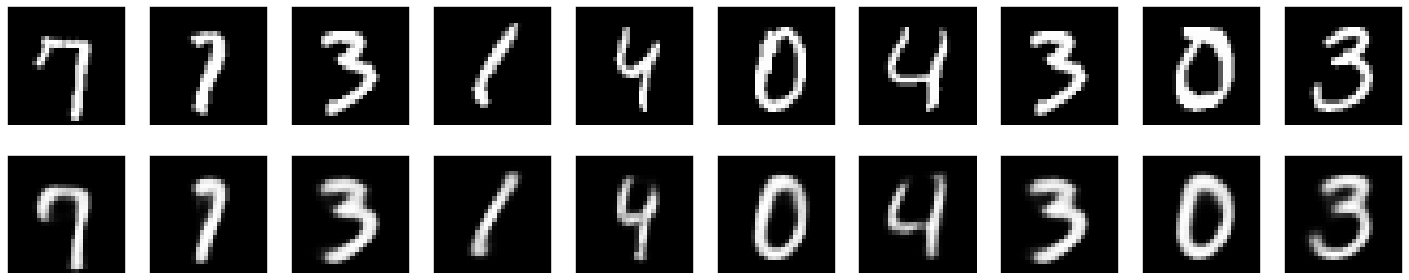

60000/60000 [==============================] - 36s 599us/sample - loss: 0.0647 - val_loss: 0.0646
Epoch 42/101
60000/60000 [==============================] - 35s 587us/sample - loss: 0.0646 - val_loss: 0.0645
Epoch 43/101
60000/60000 [==============================] - 35s 584us/sample - loss: 0.0645 - val_loss: 0.0644
Epoch 44/101
60000/60000 [==============================] - 35s 582us/sample - loss: 0.0644 - val_loss: 0.0642
Epoch 45/101
60000/60000 [==============================] - 35s 587us/sample - loss: 0.0643 - val_loss: 0.0642
Epoch 46/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0642

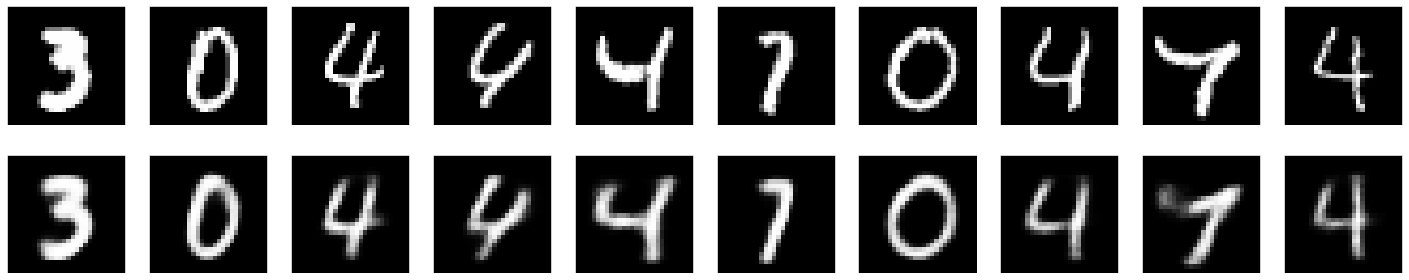

60000/60000 [==============================] - 37s 613us/sample - loss: 0.0642 - val_loss: 0.0641
Epoch 47/101
60000/60000 [==============================] - 35s 583us/sample - loss: 0.0641 - val_loss: 0.0639
Epoch 48/101
60000/60000 [==============================] - 35s 582us/sample - loss: 0.0640 - val_loss: 0.0639
Epoch 49/101
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0639 - val_loss: 0.0639
Epoch 50/101
60000/60000 [==============================] - 35s 580us/sample - loss: 0.0638 - val_loss: 0.0638
Epoch 51/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0637

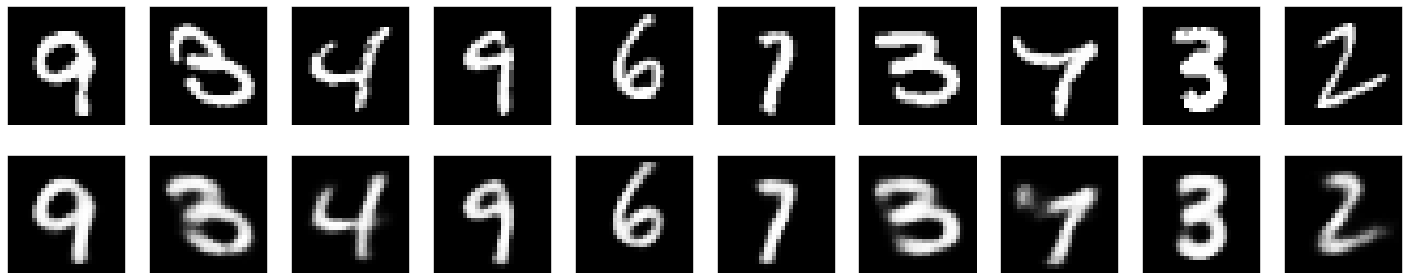

60000/60000 [==============================] - 36s 593us/sample - loss: 0.0637 - val_loss: 0.0637
Epoch 52/101
60000/60000 [==============================] - 35s 580us/sample - loss: 0.0636 - val_loss: 0.0638
Epoch 53/101
60000/60000 [==============================] - 35s 579us/sample - loss: 0.0635 - val_loss: 0.0635
Epoch 54/101
60000/60000 [==============================] - 35s 581us/sample - loss: 0.0635 - val_loss: 0.0635
Epoch 55/101
60000/60000 [==============================] - 35s 584us/sample - loss: 0.0634 - val_loss: 0.0636
Epoch 56/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0633

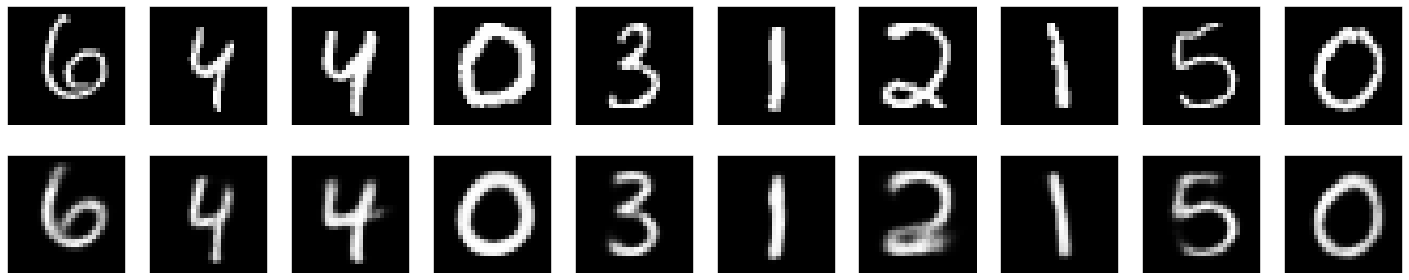

60000/60000 [==============================] - 36s 603us/sample - loss: 0.0633 - val_loss: 0.0634
Epoch 57/101
60000/60000 [==============================] - 35s 587us/sample - loss: 0.0632 - val_loss: 0.0632
Epoch 58/101
60000/60000 [==============================] - 36s 592us/sample - loss: 0.0631 - val_loss: 0.0632
Epoch 59/101
60000/60000 [==============================] - 36s 600us/sample - loss: 0.0631 - val_loss: 0.0632
Epoch 60/101
60000/60000 [==============================] - 36s 601us/sample - loss: 0.0630 - val_loss: 0.0632
Epoch 61/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0629

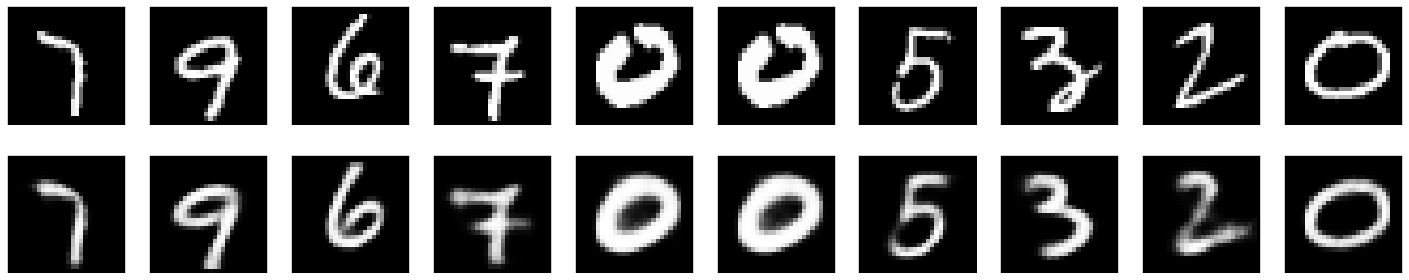

60000/60000 [==============================] - 37s 612us/sample - loss: 0.0629 - val_loss: 0.0631
Epoch 62/101
60000/60000 [==============================] - 36s 597us/sample - loss: 0.0629 - val_loss: 0.0630
Epoch 63/101
60000/60000 [==============================] - 36s 600us/sample - loss: 0.0628 - val_loss: 0.0630
Epoch 64/101
60000/60000 [==============================] - 37s 610us/sample - loss: 0.0628 - val_loss: 0.0629
Epoch 65/101
60000/60000 [==============================] - 37s 613us/sample - loss: 0.0627 - val_loss: 0.0628
Epoch 66/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0626

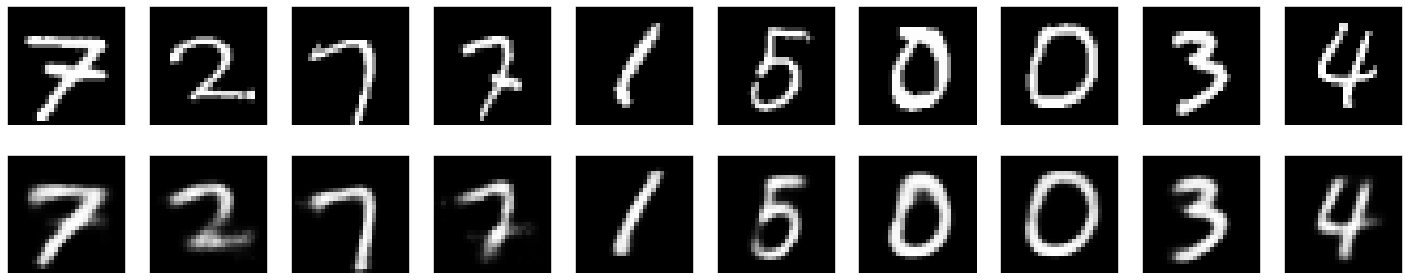

60000/60000 [==============================] - 37s 621us/sample - loss: 0.0626 - val_loss: 0.0628
Epoch 67/101
60000/60000 [==============================] - 36s 604us/sample - loss: 0.0626 - val_loss: 0.0627
Epoch 68/101
60000/60000 [==============================] - 36s 603us/sample - loss: 0.0625 - val_loss: 0.0628
Epoch 69/101
60000/60000 [==============================] - 36s 604us/sample - loss: 0.0624 - val_loss: 0.0628
Epoch 70/101
60000/60000 [==============================] - 36s 597us/sample - loss: 0.0624 - val_loss: 0.0626
Epoch 71/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0623

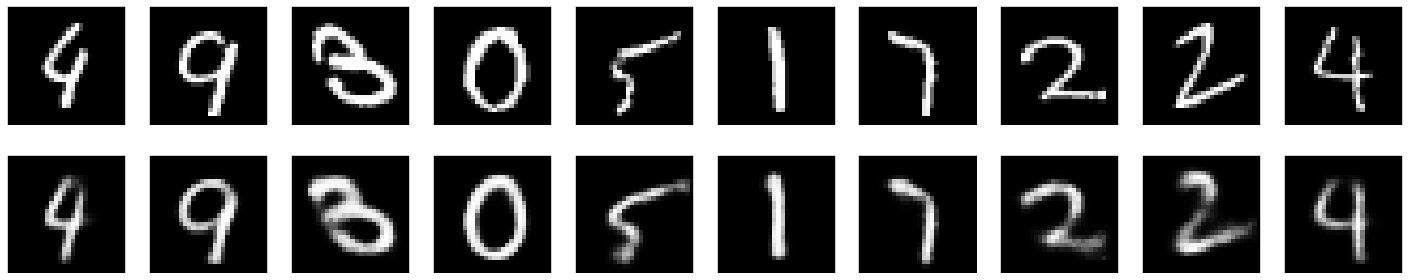

60000/60000 [==============================] - 37s 619us/sample - loss: 0.0623 - val_loss: 0.0626
Epoch 72/101
60000/60000 [==============================] - 36s 605us/sample - loss: 0.0623 - val_loss: 0.0626
Epoch 73/101
60000/60000 [==============================] - 36s 604us/sample - loss: 0.0622 - val_loss: 0.0625
Epoch 74/101
60000/60000 [==============================] - 36s 601us/sample - loss: 0.0622 - val_loss: 0.0626
Epoch 75/101
60000/60000 [==============================] - 36s 603us/sample - loss: 0.0621 - val_loss: 0.0624
Epoch 76/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0621

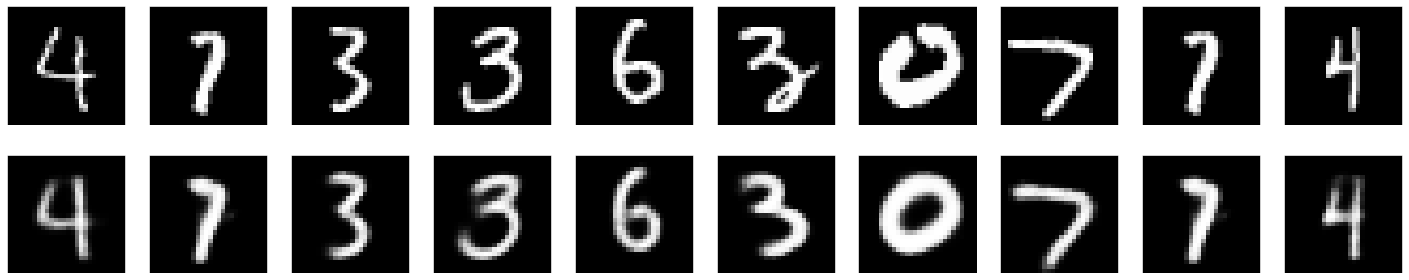

60000/60000 [==============================] - 37s 624us/sample - loss: 0.0621 - val_loss: 0.0624
Epoch 77/101
60000/60000 [==============================] - 37s 614us/sample - loss: 0.0620 - val_loss: 0.0623
Epoch 78/101
60000/60000 [==============================] - 37s 615us/sample - loss: 0.0620 - val_loss: 0.0622
Epoch 79/101
60000/60000 [==============================] - 36s 603us/sample - loss: 0.0619 - val_loss: 0.0622
Epoch 80/101
60000/60000 [==============================] - 37s 608us/sample - loss: 0.0619 - val_loss: 0.0623
Epoch 81/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0618

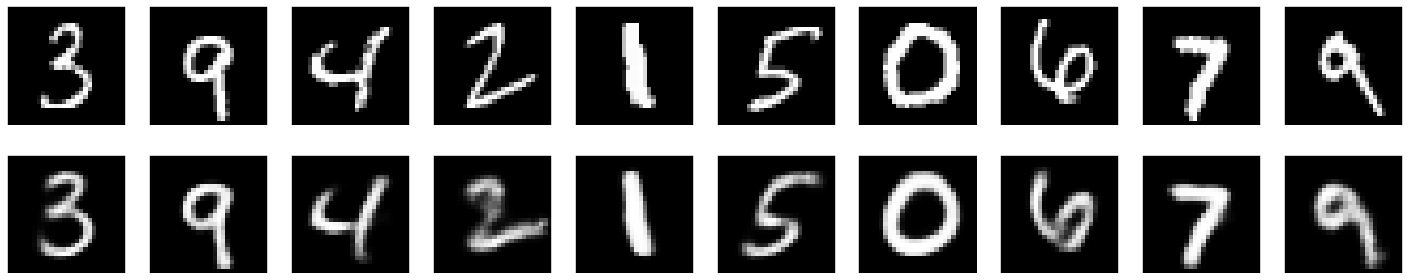

60000/60000 [==============================] - 37s 620us/sample - loss: 0.0618 - val_loss: 0.0622
Epoch 82/101
60000/60000 [==============================] - 36s 605us/sample - loss: 0.0618 - val_loss: 0.0622
Epoch 83/101
60000/60000 [==============================] - 37s 610us/sample - loss: 0.0617 - val_loss: 0.0621
Epoch 84/101
60000/60000 [==============================] - 36s 604us/sample - loss: 0.0617 - val_loss: 0.0621
Epoch 85/101
60000/60000 [==============================] - 36s 602us/sample - loss: 0.0617 - val_loss: 0.0621
Epoch 86/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0616

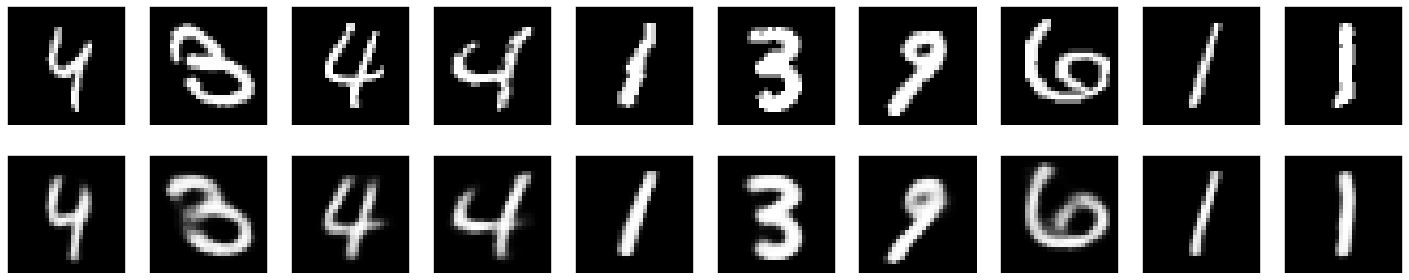

60000/60000 [==============================] - 37s 622us/sample - loss: 0.0616 - val_loss: 0.0621
Epoch 87/101
60000/60000 [==============================] - 37s 610us/sample - loss: 0.0616 - val_loss: 0.0620
Epoch 88/101
60000/60000 [==============================] - 36s 607us/sample - loss: 0.0615 - val_loss: 0.0619
Epoch 89/101
60000/60000 [==============================] - 36s 605us/sample - loss: 0.0615 - val_loss: 0.0620
Epoch 90/101
60000/60000 [==============================] - 36s 607us/sample - loss: 0.0615 - val_loss: 0.0619
Epoch 91/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0614

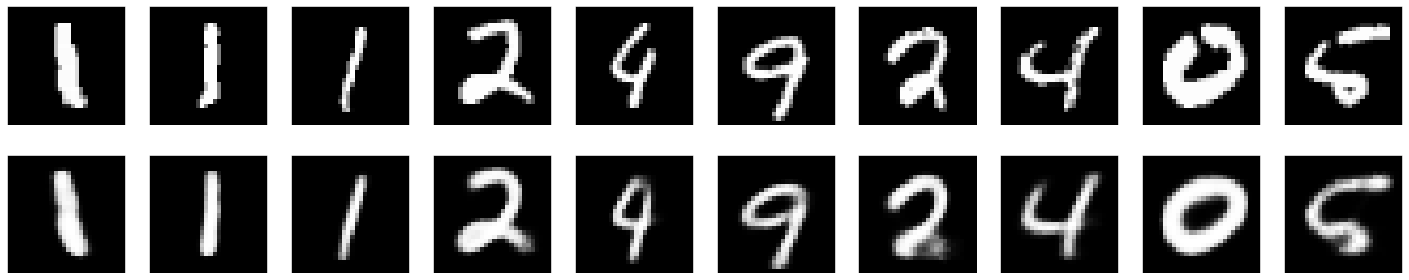

60000/60000 [==============================] - 37s 620us/sample - loss: 0.0614 - val_loss: 0.0620
Epoch 92/101
60000/60000 [==============================] - 37s 609us/sample - loss: 0.0614 - val_loss: 0.0619
Epoch 93/101
60000/60000 [==============================] - 36s 605us/sample - loss: 0.0613 - val_loss: 0.0619
Epoch 94/101
60000/60000 [==============================] - 36s 603us/sample - loss: 0.0613 - val_loss: 0.0618
Epoch 95/101
60000/60000 [==============================] - 36s 602us/sample - loss: 0.0613 - val_loss: 0.0618
Epoch 96/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0612

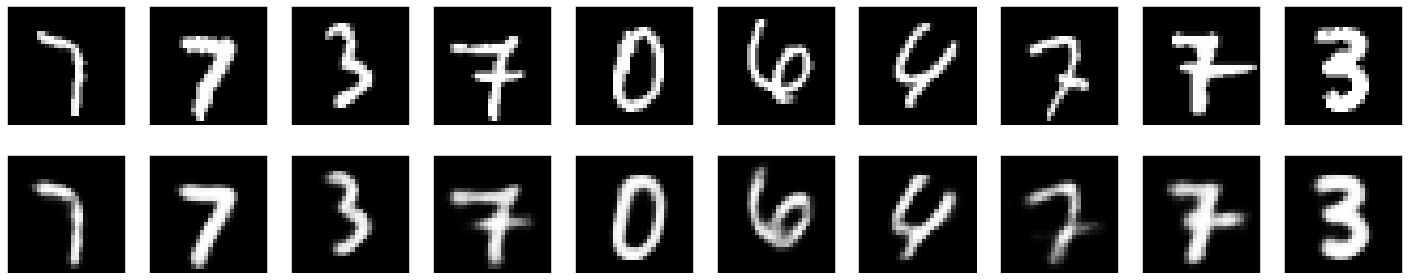

60000/60000 [==============================] - 37s 621us/sample - loss: 0.0612 - val_loss: 0.0618
Epoch 97/101
60000/60000 [==============================] - 36s 607us/sample - loss: 0.0612 - val_loss: 0.0617
Epoch 98/101
60000/60000 [==============================] - 36s 603us/sample - loss: 0.0611 - val_loss: 0.0617
Epoch 99/101
60000/60000 [==============================] - 36s 595us/sample - loss: 0.0611 - val_loss: 0.0617
Epoch 100/101
60000/60000 [==============================] - 35s 585us/sample - loss: 0.0611 - val_loss: 0.0616
Epoch 101/101
59875/60000 [============================>.] - ETA: 0s - loss: 0.0610

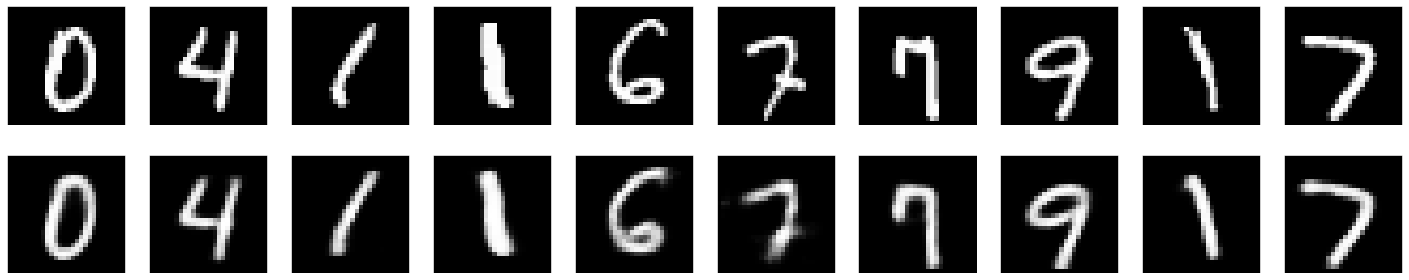

60000/60000 [==============================] - 37s 617us/sample - loss: 0.0610 - val_loss: 0.0616


In [ ]:
# Запуск обучения 
history=cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=101,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

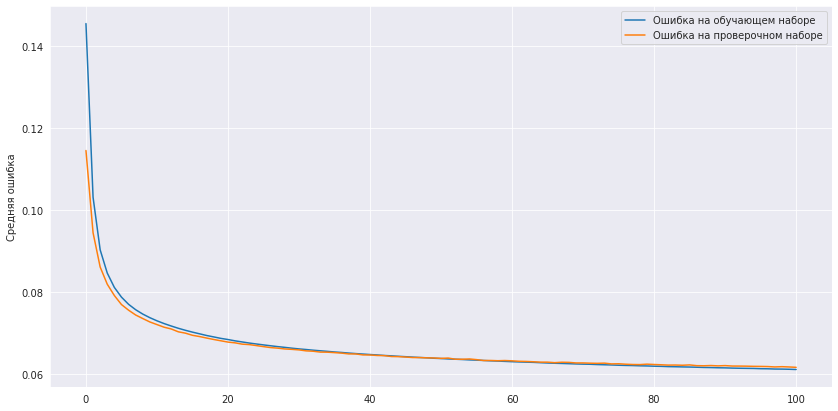

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

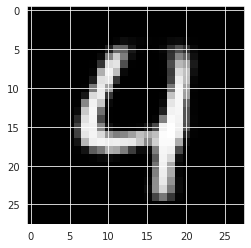

In [ ]:
shape=(28, 28)
lbl=4
imgs = x_test[y_test==lbl][:batch_size]
imgs_lbls = y_test_cat[y_test==lbl][:batch_size]
imgmy=cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)[0]
plt.imshow(imgmy.reshape(shape), cmap='Greys_r')

[5, 2, 5, 4, 3]


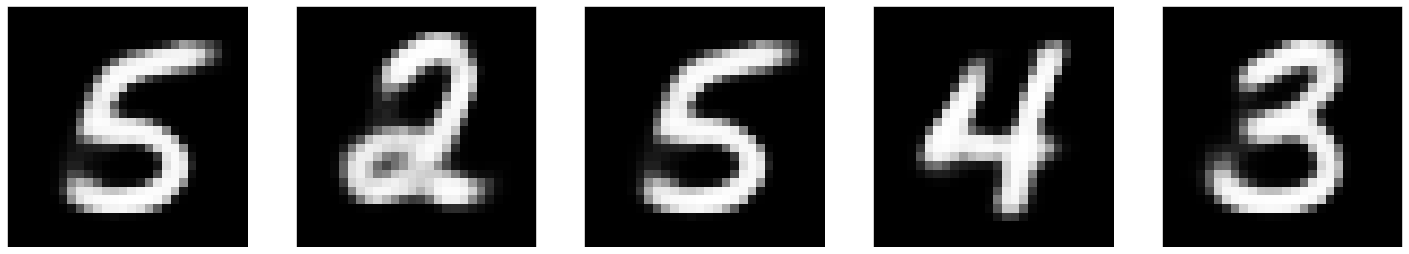

In [ ]:
sample=5
noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim])
lbls=[]
plt.figure(figsize=(25, 5)) # указываем размеры фигуры
for i in range(sample):
  lbl=np.random.randint(0,10)
  lbls.append(lbl)
  input_lbl_d=y_test_cat[y_test==lbl][0]
  input_lbl_d=input_lbl_d.reshape(1,10)
  imgmyg=generator.predict([noise,input_lbl_d])
  ax = plt.subplot(1, sample, i + 1) # выведем область рисования Axes
  plt.imshow(imgmyg.reshape(shape), cmap='Greys_r')
  ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
  ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
print(lbls)

6


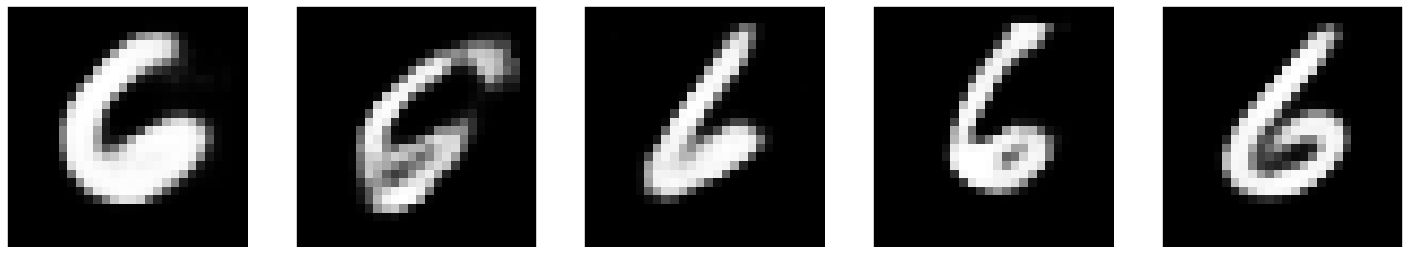

In [ ]:
sample=5
lbl=np.random.randint(0,10)
input_lbl_d=y_test_cat[y_test==lbl][0]
input_lbl_d=input_lbl_d.reshape(1,10)
plt.figure(figsize=(25, 5)) # указываем размеры фигуры
for i in range(sample):
  noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim])
  imgmyg2=generator.predict([noise,input_lbl_d])
  ax = plt.subplot(1, sample, i + 1) # выведем область рисования Axes
  plt.imshow(imgmyg2.reshape(shape), cmap='Greys_r')
  ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
  ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
print(lbl)